In [4]:
DATADIR = '20 bin PPO 500 results/'
SOC = 25
BINS = 20

In [5]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

%matplotlib inline

In [21]:
cont_bins = np.linspace(-1.0, 1.0, BINS)

These are the action mappings we expect for our discrete agent, with negative specifying a battery discharge and positive charge

In [22]:
cont_bins

array([-1.        , -0.89473684, -0.78947368, -0.68421053, -0.57894737,
       -0.47368421, -0.36842105, -0.26315789, -0.15789474, -0.05263158,
        0.05263158,  0.15789474,  0.26315789,  0.36842105,  0.47368421,
        0.57894737,  0.68421053,  0.78947368,  0.89473684,  1.        ])

In [7]:
data_dir = os.path.join(os.getcwd(), '..','..', DATADIR)
data_dir = os.path.normpath(data_dir) #resolve '..'

In [8]:
df_obs = pd.read_csv(data_dir + '/rebaseline obs.csv',
                     header=None,
                     dtype='float32')
df_obs.set_index(df_obs.index.astype(int), inplace=True)

In [9]:
s_a = pd.read_csv(data_dir + '/rebaseline a.csv',
                    header=None,
                    dtype='float32')
s_a.set_index(s_a.index.astype(int), inplace=True)

The agent's action either tells the battery to charge or discharge to a certain percentage, while the observation is the current charge state. We can tell if the battery is charging or discharging based on the difference between two samples.

In [28]:
soc_bins = np.linspace(-1.0, 1.0, BINS)[-10:] #this should include 0, which correspond to -1
soc_bins = np.insert(soc_bins, 0, 0.0)

In [29]:
soc_bins

array([0.        , 0.05263158, 0.15789474, 0.26315789, 0.36842105,
       0.47368421, 0.57894737, 0.68421053, 0.78947368, 0.89473684,
       1.        ])

In [36]:
binned_soc = pd.cut(df_obs[SOC], soc_bins, 
                    #labels=False, #returns indexes instead of range
                    include_lowest=True #otherwise 0.0 is excluded
                    ) 

This tells us which bin an observation falls into, but we need to know which is the closest bin value. Maybe we should shift our soc bins over by half a bine, so the boundary is half way between two actions?

In [37]:
binned_soc.value_counts()

(-0.001, 0.0526]    3136
(0.895, 1.0]        1726
(0.263, 0.368]       563
(0.579, 0.684]       546
(0.158, 0.263]       529
(0.368, 0.474]       514
(0.789, 0.895]       497
(0.0526, 0.158]      458
(0.474, 0.579]       400
(0.684, 0.789]       390
Name: 25, dtype: int64

<Axes: ylabel='Frequency'>

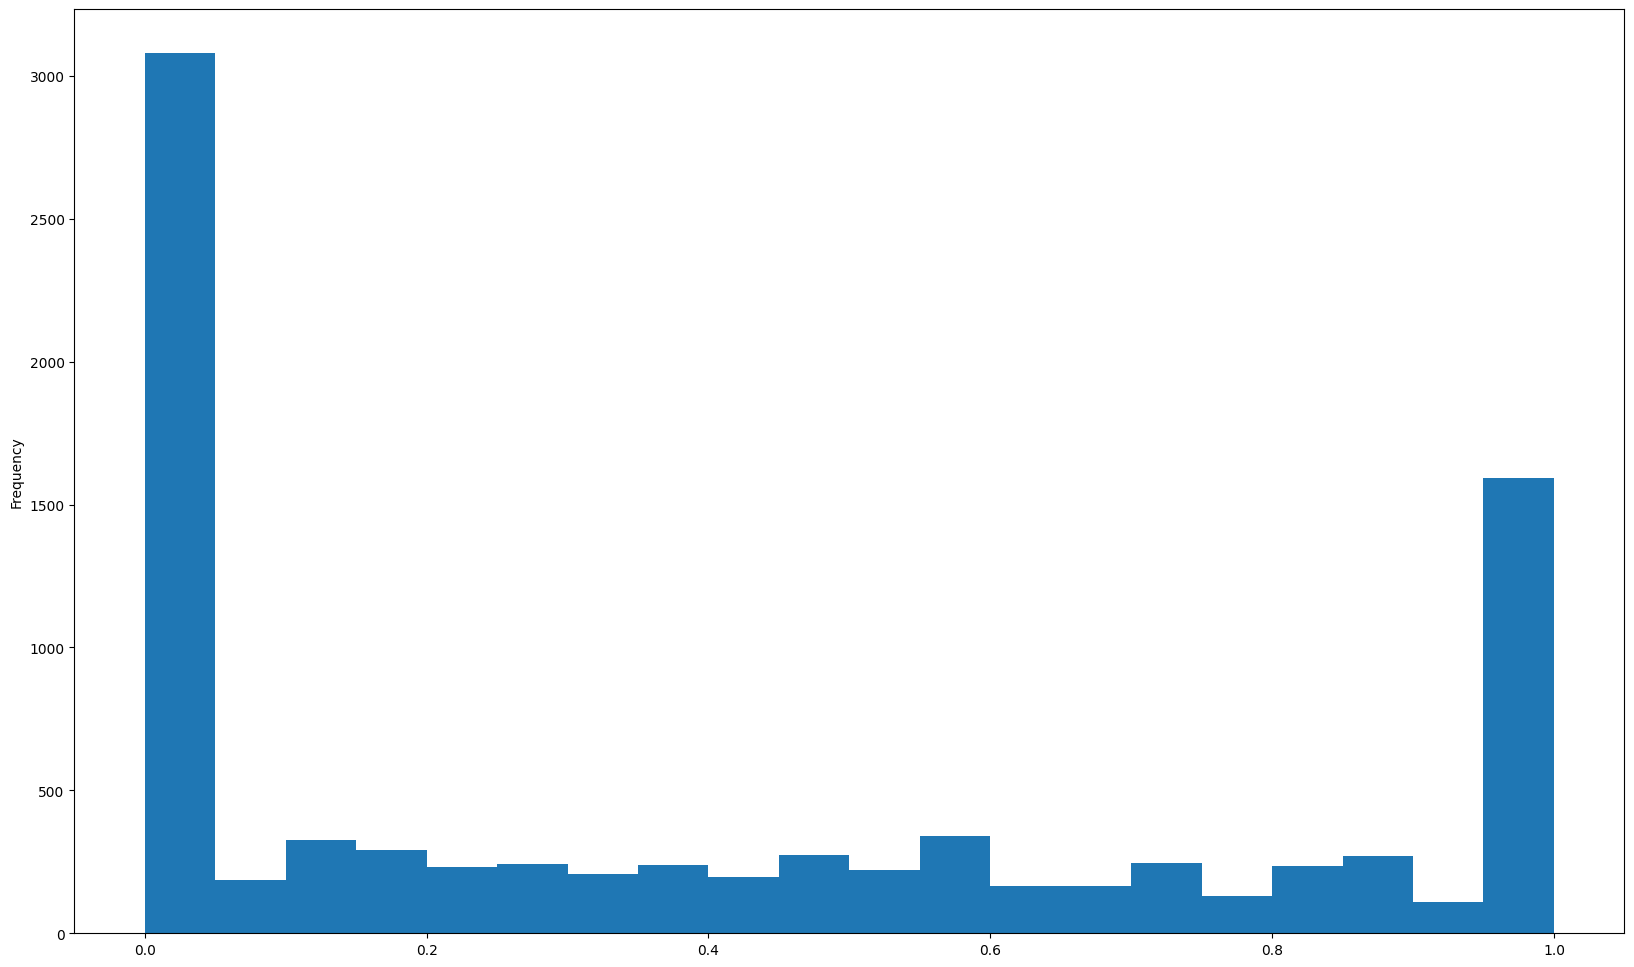

In [45]:
df_obs[SOC].plot.hist(bins=BINS,
                      figsize=(20,12),
)

<Axes: ylabel='Frequency'>

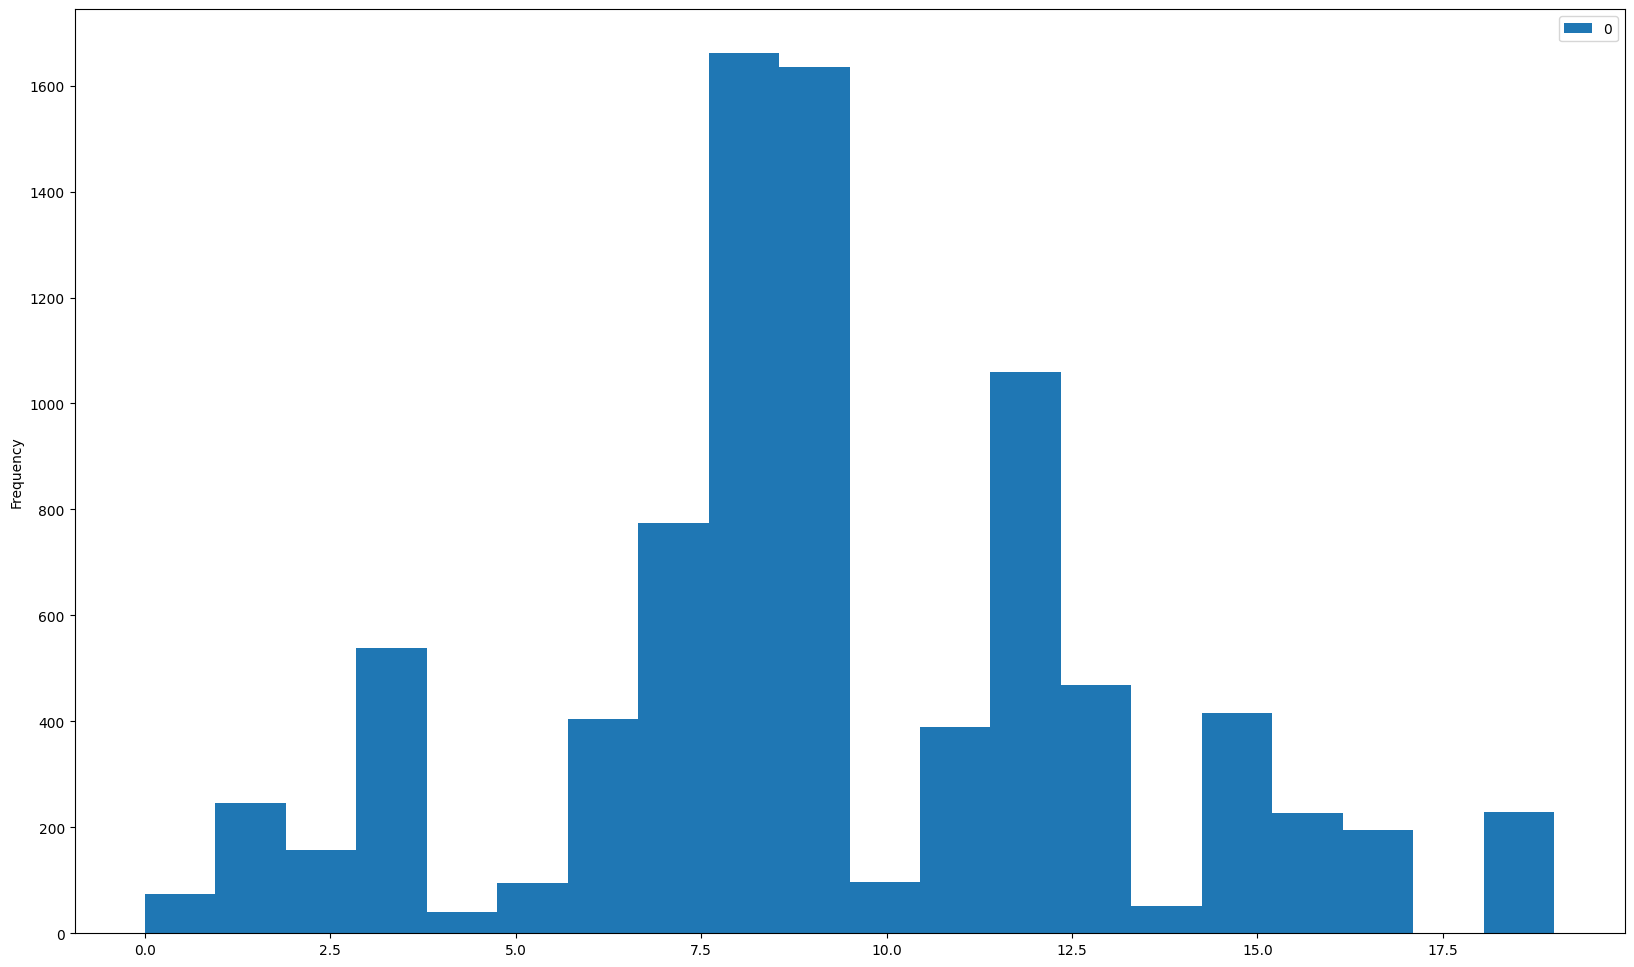

In [48]:
s_a.plot.hist(bins=BINS,
                      figsize=(20,12),
)

In [ ]:
df_soc_a = pd.DataFrame({'soc':df_obs[SOC], 'a':s_a[0]})


Map continuous discrete actions to continuous space [-1.0, 1.0]

In [59]:
df_soc_a['a'] = df_soc_a['a'].map(dict(enumerate(cont_bins))) #converts array of continuous actions to a dict

<Axes: >

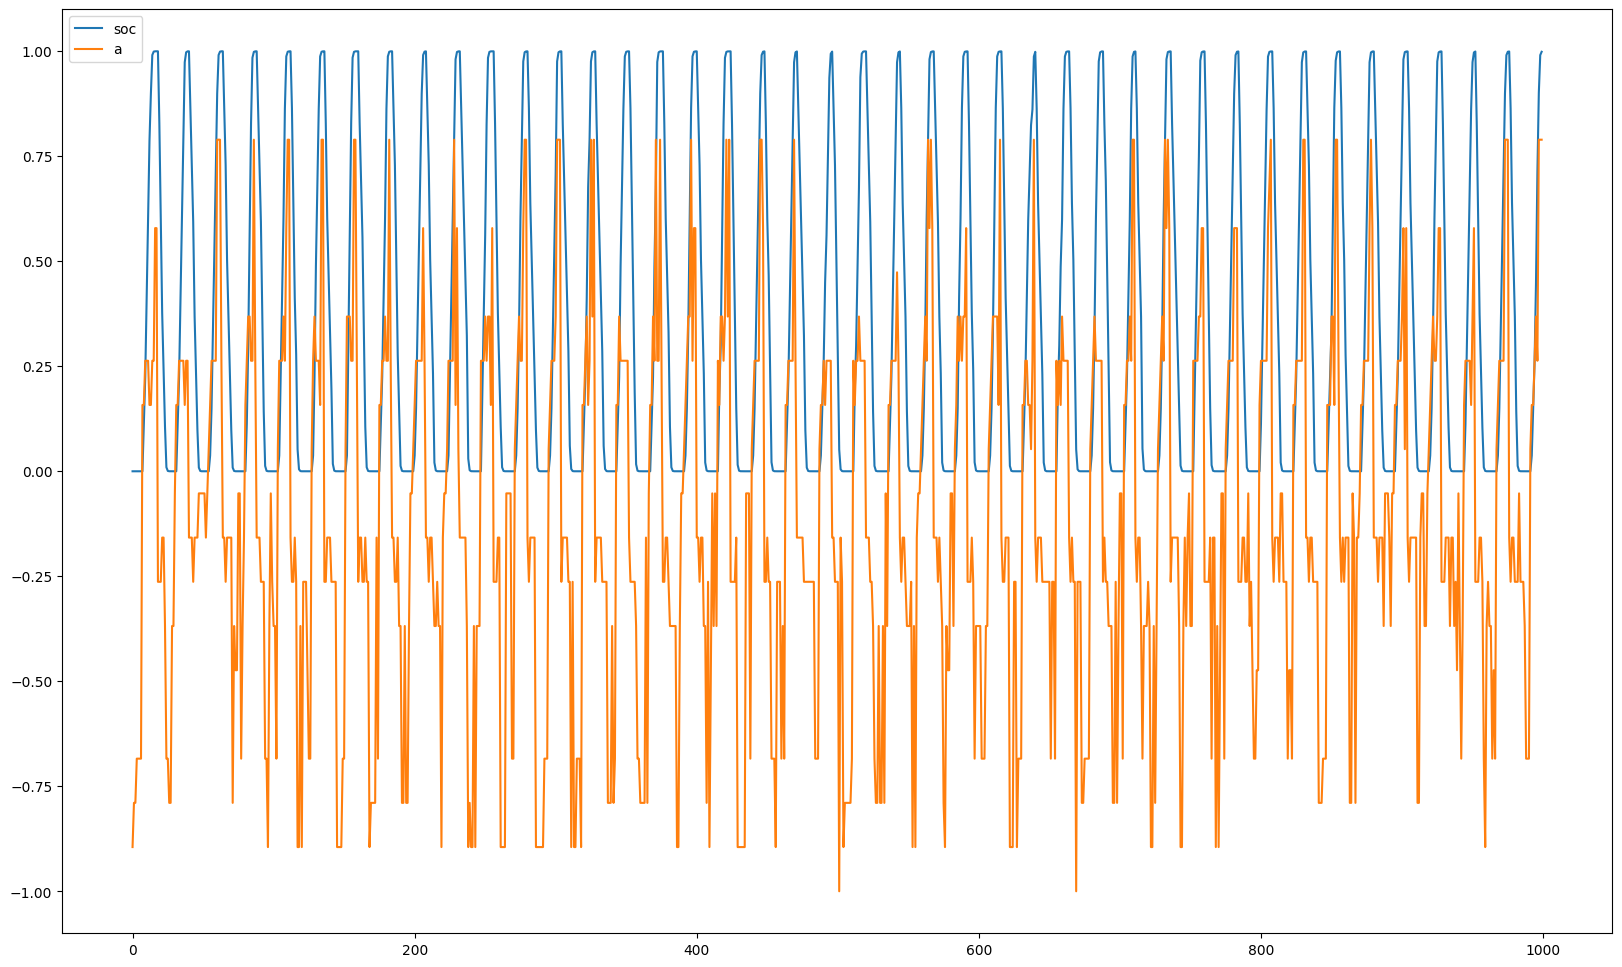

In [62]:
df_soc_a.iloc[:1000,:].plot.line(figsize=(20,12),)

In [61]:
df_soc_a.corr()

,soc,a
soc,1.000000,0.582823
a,0.582823,1.000000


In [47]:
df_obs[SOC].diff(periods=-1).round(2).describe()

count    8758.00000
mean        0.00137
std         0.12067
min        -0.56000
25%        -0.01000
50%         0.00000
75%         0.05000
max         0.41000
Name: 25, dtype: float64

We see that a difference of 0-9 corresponds to a positve difference between two measurements, so these mean charging

We're rounding by 2 since 1/20 bins is 0.05

In [49]:
s_a[df_obs[SOC].diff(periods=-1).round(2)>0].value_counts()

8.0    1390
9.0    1004
7.0     590
6.0     113
3.0      78
1.0      38
0.0      13
2.0       9
5.0       8
4.0       6
dtype: int64

11-19 correspond to discharging

In [50]:
s_a[df_obs[SOC].diff(periods=-1).round(2)<0].value_counts()

12.0    971
13.0    435
11.0    376
15.0    154
19.0     95
10.0     88
17.0     78
16.0     68
14.0     36
dtype: int64

What if we don't round?

In [62]:
s_a[df_obs[SOC].diff(periods=-1)>0].value_counts()

8.0    1661
9.0    1636
7.0     775
3.0     534
6.0     404
1.0     244
2.0     155
5.0      95
0.0      74
4.0      41
dtype: int64

In [63]:
s_a[df_obs[SOC].diff(periods=-1)<0].value_counts()

12.0    1060
13.0     468
15.0     414
11.0     390
19.0     229
16.0     218
17.0     194
10.0      96
14.0      52
dtype: int64

If we don't round, 10 is grouped with discharging

If the difference is 0 we expect the same action was used twice, note there may be some errors due to inprecision

In [64]:
s_a[df_obs[SOC].diff(periods=-1)==0].value_counts()

16.0    9
3.0     4
2.0     2
0.0     1
1.0     1
15.0    1
dtype: int64

Now let's check what SOC value corresponds to each action:

looks like action 0 is a full discharge

In [110]:
a = 0 #action in question
a_idx = np.where(s_a[0] == a)[0] #ts where an action was selected
a_idx += 1 # the next ts where the env has changed based on the action
df_obs[SOC][a_idx].round(2).value_counts() #SOC after the action

0.00    71
0.01     3
0.02     1
Name: 25, dtype: int64

19 is indeed a full charge

In [109]:
a = 19 #action in question
a_idx = np.where(s_a[0] == a)[0] #ts where an action was selected
a_idx += 1 # the next ts where the env has changed based on the action
df_obs[SOC][a_idx].round(2).value_counts() #SOC after the action

1.00    189
0.98     14
0.99     14
0.97     12
Name: 25, dtype: int64

In [113]:
a = 15 #action in question
a_idx = np.where(s_a[0] == a)[0] #ts where an action was selected
a_idx += 1 # the next ts where the env has changed based on the action
df_obs[SOC][a_idx].round(2).value_counts() #SOC after the action

1.00    344
0.99     30
0.98     26
0.97     15
Name: 25, dtype: int64

In [107]:
a = 10 #action in question
a_idx = np.where(s_a[0] == a)[0] #ts where an action was selected
a_idx += 1 # the next ts where the env has changed based on the action
df_obs[SOC][a_idx].round(2).value_counts() #SOC after the action

0.04    70
1.00     9
0.79     3
0.07     3
0.75     2
0.13     2
0.86     1
0.82     1
0.41     1
0.60     1
0.22     1
0.71     1
0.40     1
Name: 25, dtype: int64

In [114]:
a = 5 #action in question
a_idx = np.where(s_a[0] == a)[0] #ts where an action was selected
a_idx += 1 # the next ts where the env has changed based on the action
df_obs[SOC][a_idx].round(2).value_counts() #SOC after the action

0.00    91
0.01     3
0.02     1
Name: 25, dtype: int64

What if the action specifies to add som percentation of capacity, like charge 40% more than the current SoC? we can check the difference in SoC between the ts where the action was taken and the next. If this was the case we'd expect the difference to be constance (or smaller when the SoC reaches it's boundary)

In [105]:
df_obs[SOC][s_a[0] == 8].diff(1).round(2).value_counts()

-0.14    835
-0.00    133
 1.00     66
-0.36     65
-0.18     35
        ... 
-0.38      1
 0.79      1
 0.13      1
 0.46      1
-0.73      1
Name: 25, Length: 101, dtype: int64

In [103]:
df_obs[SOC][s_a[0] == 9].diff(1).round(2).value_counts()

-0.05    723
-0.00    525
-0.18     50
-0.01     31
 1.00     31
        ... 
 0.31      1
 0.10      1
 0.25      1
-0.33      1
 0.36      1
Name: 25, Length: 81, dtype: int64

In [108]:
df_obs[SOC][s_a[0] == 0].diff(1).round(2).value_counts()

 0.00    58
 0.01     3
-0.01     3
 0.02     2
 0.08     2
-0.05     1
 0.04     1
-0.04     1
-0.02     1
 0.09     1
-0.17     1
Name: 25, dtype: int64

In [115]:
df_obs[SOC][s_a[0] == 10].diff(1).round(2).value_counts()

-0.00    52
 1.00     7
-1.00     6
 0.04     6
-0.04     3
 0.09     2
 0.99     2
-0.99     2
 0.37     2
-0.37     1
-0.10     1
-0.36     1
-0.31     1
 0.49     1
 0.71     1
-0.19     1
-0.79     1
-0.75     1
-0.29     1
-0.82     1
 0.82     1
-0.09     1
Name: 25, dtype: int64

In [118]:
df_obs[SOC][s_a[0] == 15].diff(1).round(2).value_counts()

 0.00    176
 0.01     38
 0.02     27
-0.01     17
-0.02     15
 0.09     10
-0.28      9
 0.16      8
-0.17      8
 0.28      7
-0.10      7
-0.06      6
 0.13      6
 0.26      6
-0.14      6
-0.32      5
 0.30      4
-0.07      3
-0.09      3
 0.03      3
 0.06      3
 0.05      3
-0.26      3
 0.17      2
 0.32      2
 0.15      2
-0.03      2
-0.19      2
 0.14      2
-0.16      2
 0.12      2
 0.23      2
-0.25      2
-0.13      2
-0.40      1
 0.08      1
 0.18      1
 0.40      1
-0.12      1
 0.24      1
 0.38      1
-0.39      1
-0.27      1
-0.20      1
 0.04      1
 0.21      1
-0.21      1
-0.11      1
 0.19      1
-0.29      1
-0.31      1
-0.15      1
 0.10      1
Name: 25, dtype: int64